<a href="https://colab.research.google.com/github/ngyxntthaoo/IS6404.CH201-Phan-tich-du-lieu-nang-cao/blob/main/Lab_4_Traditional_Data_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 4: Tổng quan các kỹ thuật phân tích dữ liệu cổ điển
**Course:** IS6404 - Advanced Data Analysis, UIT, VNUHCM  
**Lecturer:** Dr. Tran Hung Nghiep, 2026  

---

Mục tiêu của buổi này không phải học sâu công thức, mà là:
- Biết **khi nào dùng** các kỹ thuật cổ điển (regression, hypothesis testing, optimization)
- Biết dùng chúng như **baseline** và **công cụ kiểm chứng** trong pipeline ML/AI
- Hiểu các **hạn chế** (assumptions, leakage, p-hacking, overfitting, constraint mismatch)

> Notebook này có 3 phần chính: **Hồi quy**, **Kiểm chứng giả thuyết**, **Tối ưu**.  
> Mỗi phần đều có câu hỏi để người học trả lời.

## 0. Setup & Reproducibility
Cố định seed, in versions, tạo thư mục outputs.

In [ ]:
# 0) Setup
import json, os, sys, platform
from datetime import datetime

import numpy as np
import pandas as pd
import sklearn

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

OUTPUT_DIR = "outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("python:", sys.version)
print("platform:", platform.platform())
print("numpy:", np.__version__)
print("pandas:", pd.__version__)
print("sklearn:", sklearn.__version__)


python: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
platform: Linux-6.6.105+-x86_64-with-glibc2.35
numpy: 2.0.2
pandas: 2.2.2
sklearn: 1.6.1


## 1. Dataset (dữ liệu mẫu cho regression + hypothesis testing)

Ta dùng dataset `diabetes` từ scikit-learn (có sẵn, chạy nhanh).
- Target: tiến triển bệnh (một đại lượng liên tục) -> phù hợp regression
- Có feature `sex` (đã chuẩn hóa) -> tạo điều kiện làm kiểm chứng giả thuyết giữa 2 nhóm

> Trong đồ án thật, hãy giữ cấu trúc notebook và thay bằng dataset của nhóm.


In [ ]:
from sklearn.datasets import load_diabetes

data = load_diabetes(as_frame=True)
df = data.frame.copy()
df.rename(columns={"target": "y"}, inplace=True)

df.head()


,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,y
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641,135.0


In [ ]:
print("shape:", df.shape)
df.describe().T.head(12)


shape: (442, 11)


,count,mean,std,min,25%,50%,75%,max
age,442.0,-2.511817e-19,0.047619,-0.107226,-0.037299,0.005383,0.038076,0.110727
sex,442.0,1.230790e-17,0.047619,-0.044642,-0.044642,-0.044642,0.050680,0.050680
bmi,442.0,-2.245564e-16,0.047619,-0.090275,-0.034229,-0.007284,0.031248,0.170555
bp,442.0,-4.797570e-17,0.047619,-0.112399,-0.036656,-0.005670,0.035644,0.132044
s1,442.0,-1.381499e-17,0.047619,-0.126781,-0.034248,-0.004321,0.028358,0.153914
s2,442.0,3.918434e-17,0.047619,-0.115613,-0.030358,-0.003819,0.029844,0.198788
s3,442.0,-5.777179e-18,0.047619,-0.102307,-0.035117,-0.006584,0.029312,0.181179
s4,442.0,-9.042540e-18,0.047619,-0.076395,-0.039493,-0.002592,0.034309,0.185234
s5,442.0,9.293722e-17,0.047619,-0.126097,-0.033246,-0.001947,0.032432,0.133597
s6,442.0,1.130318e-17,0.047619,-0.137767,-0.033179,-0.001078,0.027917,0.135612


## 2. Hồi quy tuyến tính (Linear Regression) như baseline + interpretability

### Vai trò trong pipeline ML/AI
- Baseline mạnh, dễ giải thích
- Kiểm tra nhanh mối quan hệ tuyến tính và multicollinearity
- Tạo feature/insight trước khi dùng model phức tạp

### Cảnh báo
- Assumptions (tuyến tính, độc lập, phương sai đồng nhất, sai số gần chuẩn) thường **không hoàn hảo**
- Không suy ra nhân quả chỉ từ hồi quy

### **Câu hỏi**
1) Với dữ liệu của nhóm bạn, hồi quy tuyến tính có thể là baseline không? Vì sao?
2) Nếu feature có quan hệ phi tuyến, dấu hiệu nào cho thấy OLS không phù hợp?


### 2.1 Train/Test split (để tránh đánh giá ảo)

In [35]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=["y"])
y = df["y"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED
)
X_train.shape, X_test.shape


((60800, 17), (15200, 17))

### 2.2 Linear regression bằng scikit-learn

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

linreg = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LinearRegression())
])

linreg.fit(X_train, y_train)
pred = linreg.predict(X_test)

mae = mean_absolute_error(y_test, pred)
mse = mean_squared_error(y_test, pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, pred)

{"test_MAE": mae, "test_RMSE": rmse, "test_R2": r2}


{'test_MAE': 42.79409467959994,
 'test_RMSE': np.float64(53.85344583676592),
 'test_R2': 0.4526027629719197}

### 2.3 Hồi quy OLS bằng statsmodels để xem hệ số và p-values

In [ ]:
import statsmodels.api as sm

X_train_sm = sm.add_constant(X_train)  # thêm intercept
ols = sm.OLS(y_train, X_train_sm).fit()
ols.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.528
Model:                            OLS   Adj. R-squared:                  0.514
Method:                 Least Squares   F-statistic:                     38.25
Date:                Sat, 31 Jan 2026   Prob (F-statistic):           5.41e-50
Time:                        09:28:39   Log-Likelihood:                -1906.1
No. Observations:                 353   AIC:                             3834.
Df Residuals:                     342   BIC:                             3877.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        151.3456      2.902     52.155      0.000     145.638     157.053
age           37.9040     69.056      0.549      0.583     -97.923     173.731
sex         -241.9644     68.570     -3.529      0.000    -376.836    -107.093
bmi          542.4288     76.956      7.049      0.000     391.062     693.795
bp           347.7038     71.357      4.873      0.000     207.350     488.057
s1          -931.4888    451.138     -2.065      0.040   -1818.844     -44.134
s2           518.0623    364.114      1.423      0.156    -198.122    1234.247
s3           163.4200    233.014      0.701      0.484    -294.901     621.741
s4           275.3179    185.400      1.485      0.138     -89.349     639.985
s5           736.1989    192.437      3.826      0.000     357.689    1114.709
s6            48.6707     73.435      0.663      0.508     -95.771     193.113
==============================================================================
Omnibus:                        1.457   Durbin-Watson:                   1.794
Prob(Omnibus):                  0.483   Jarque-Bera (JB):                1.412
Skew:                           0.064   Prob(JB):                        0.494
Kurtosis:                       2.718   Cond. No.                         219.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Gợi ý đọc kết quả OLS (đơn giản):**
- `coef`: hướng và độ mạnh ảnh hưởng (theo mô hình tuyến tính)
- `P>|t|`: p-value của giả thuyết hệ số = 0 (cẩn thận diễn giải)
- `R-squared`: mức giải thích biến thiên (không phải thước đo duy nhất)

> Trong ML hiện đại, p-value không phải lúc nào cũng là trọng tâm, nhưng nó hữu ích để **kiểm tra nhanh** và **diễn giải**.


### 2.4 Chẩn đoán nhanh: residuals (dấu hiệu phi tuyến / outliers)

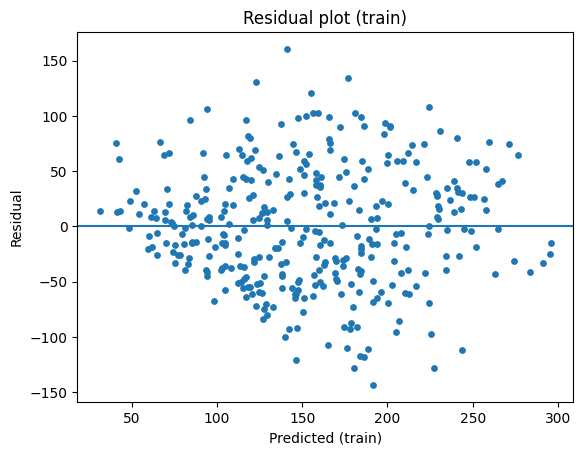

In [ ]:
import matplotlib.pyplot as plt

pred_train = ols.predict(sm.add_constant(X_train))
resid = y_train - pred_train

plt.figure()
plt.scatter(pred_train, resid, s=15)
plt.axhline(0)
plt.xlabel("Predicted (train)")
plt.ylabel("Residual")
plt.title("Residual plot (train)")
plt.show()


## 3. Hồi quy phi tuyến (Non-linear regression) dưới dạng feature engineering

Thay vì đi sâu các mô hình phi tuyến cổ điển, ta dùng cách thực dụng:
- **Polynomial features + regularization** để bắt quan hệ phi tuyến
- So sánh với OLS baseline

### Vai trò trong pipeline
- Tạo baseline phi tuyến đơn giản trước khi dùng tree/NN
- Cho thấy lợi ích của feature engineering

### **Câu hỏi**
1) Polynomial degree tăng sẽ gây rủi ro gì?
2) Vì sao regularization (Ridge/Lasso) thường cần khi thêm polynomial features?


In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

poly_ridge = Pipeline([
    ("scaler", StandardScaler()),
    ("poly", PolynomialFeatures(include_bias=False)),
    ("model", Ridge(random_state=RANDOM_SEED))
])

param_grid = {
    "poly__degree": [1, 2, 3],
    "model__alpha": [0.1, 1.0, 10.0, 100.0],
}

gs = GridSearchCV(poly_ridge, param_grid, cv=5, scoring="neg_mean_absolute_error")
gs.fit(X_train, y_train)

best = gs.best_estimator_
pred = best.predict(X_test)

mae = mean_absolute_error(y_test, pred)
mse = mean_squared_error(y_test, pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, pred)

gs.best_params_, {"test_MAE": mae, "test_RMSE": rmse, "test_R2": r2}


({'model__alpha': 10.0, 'poly__degree': 1},
 {'test_MAE': 42.85682524780061,
  'test_RMSE': np.float64(53.62628756889519),
  'test_R2': 0.4572109567780849})

## Minh hoạ assumption violation gây sai lệch

- heteroscedasticity
- multicollinearity
- overfitting khi degree tăng

In [ ]:
from sklearn.metrics import mean_absolute_error

for deg in [1,2,3,5,8]:
    model = Pipeline([
        ("scaler", StandardScaler()),
        ("poly", PolynomialFeatures(degree=deg, include_bias=False)),
        ("lr", LinearRegression())
    ])
    model.fit(X_train, y_train)
    print("degree", deg, "MAE", mean_absolute_error(y_test, model.predict(X_test)))


degree 1 MAE 42.794094679599944
degree 2 MAE 43.58169325465275
degree 3 MAE 164.8538972836308
degree 5 MAE 226.571280075446
degree 8 MAE 957.360809195518


## 4. Kiểm chứng giả thuyết (Hypothesis Testing) để kiểm tra claim

### Vai trò trong pipeline ML/AI
- Kiểm tra khác biệt giữa nhóm (A/B, cohort, segment)
- Kiểm tra feature có liên hệ đáng kể với target không
- Hỗ trợ data understanding và error analysis

### Giới hạn và rủi ro
- p-value không đo “mức độ quan trọng thực tế” (cần effect size, CI)
- Nhiều phép thử -> tăng false positives (p-hacking)
- Giả định phân phối có thể không đúng -> cân nhắc permutation/bootstrapping

### **Câu hỏi**
1) p-value nhỏ nghĩa là gì? p-value không có nghĩa là gì?
2) Vì sao cần effect size/CI bên cạnh p-value?


### 4.1 Tạo 2 nhóm theo feature `sex`
Trong dataset này, `sex` đã chuẩn hóa quanh 0. Ta tách nhóm theo dấu.

In [ ]:
df2 = df.copy()
df2["sex_group"] = np.where(df2["sex"] >= 0, "group_A", "group_B")

df2["sex_group"].value_counts(), df2.groupby("sex_group")["y"].mean()


(sex_group
 group_B    235
 group_A    207
 Name: count, dtype: int64,
 sex_group
 group_A    155.666667
 group_B    149.021277
 Name: y, dtype: float64)

### 4.2 Two-sample t-test (so sánh trung bình y giữa 2 nhóm)

In [ ]:
from scipy import stats

a = df2.loc[df2["sex_group"] == "group_A", "y"].values
b = df2.loc[df2["sex_group"] == "group_B", "y"].values

t_stat, p_val = stats.ttest_ind(a, b, equal_var=False)  # Welch's t-test
t_stat, p_val


(np.float64(0.9022224453390377), np.float64(0.3674449793083975))

### 4.3 Effect size (Cohen's d) + confidence interval (bootstrap)

In [ ]:
def cohens_d(x, y):
    nx, ny = len(x), len(y)
    vx, vy = np.var(x, ddof=1), np.var(y, ddof=1)
    pooled = ((nx-1)*vx + (ny-1)*vy) / (nx+ny-2)
    return (np.mean(x) - np.mean(y)) / np.sqrt(pooled)

d = cohens_d(a, b)
d


np.float64(0.08618180539347013)

In [ ]:
# Bootstrap CI for mean difference
def bootstrap_mean_diff(x, y, n=5000, seed=RANDOM_SEED):
    rng = np.random.default_rng(seed)
    diffs = []
    for _ in range(n):
        xb = rng.choice(x, size=len(x), replace=True)
        yb = rng.choice(y, size=len(y), replace=True)
        diffs.append(np.mean(xb) - np.mean(yb))
    return np.percentile(diffs, [2.5, 50, 97.5])

ci = bootstrap_mean_diff(a, b)
ci  # [2.5%, 50%, 97.5%]


array([-6.95382876,  6.66865043, 20.90665433])

### 4.4 Permutation test (khi muốn giảm phụ thuộc vào giả định phân phối)

In [37]:
def permutation_test_mean_diff(x, y, n=5000, seed=RANDOM_SEED):
    rng = np.random.default_rng(seed)
    obs = np.mean(x) - np.mean(y)
    pooled = np.concatenate([x, y]).copy()
    nx = len(x)
    diffs = []
    for _ in range(n):
        rng.shuffle(pooled)
        diffs.append(np.mean(pooled[:nx]) - np.mean(pooled[nx:]))
    diffs = np.array(diffs)
    p = (np.abs(diffs) >= abs(obs)).mean()
    return obs, p

obs, p_perm = permutation_test_mean_diff(a, b)
obs, p_perm


(np.float64(28.242556862745104), np.float64(0.0))

## Minh hoạ về multiple testing và p-hacking

In [36]:
from scipy import stats

pvals = []
for col in X.columns:
    r, p = stats.pearsonr(X[col], y)
    pvals.append((col, p))

sorted(pvals, key=lambda x: x[1])[:50]


AttributeError: 'numpy.dtypes.ObjectDType' object has no attribute 'dtype'

## 5. Tối ưu (Optimization) như một module trong hệ thống dữ liệu

### Vai trò trong pipeline ML/AI
- Sau khi dự báo/ước lượng (ML), ta cần **ra quyết định** (optimization)
- Ví dụ:
  - dự báo nhu cầu -> tối ưu tồn kho
  - dự báo churn -> tối ưu phân bổ ngân sách giữ chân
  - scoring khách hàng -> tối ưu chọn top-K theo ràng buộc

### Bài lab: 2 bài toán minh họa
A) Linear Programming: tối ưu product mix (tuyến tính, ràng buộc tuyến tính)  
B) Non-linear Optimization: tối ưu giá (có độ cong, không tuyến tính)

### **Câu hỏi**
1) Vì sao optimization thường đứng sau ML trong hệ thống thực?
2) Khi nào mô hình tối ưu tuyến tính không phù hợp?


### 5A. Linear Programming (LP): Product mix optimization
Bài toán: chọn sản lượng 3 sản phẩm để tối đa lợi nhuận, bị giới hạn bởi tài nguyên.

In [ ]:
import numpy as np
from scipy.optimize import linprog

# Decision variables: x1, x2, x3 (sản lượng 3 sản phẩm)
profit = np.array([30, 20, 25])  # lợi nhuận / đơn vị

# Constraints (Ax <= b)
# Resource 1: 2x1 + 1x2 + 1x3 <= 100
# Resource 2: 1x1 + 3x2 + 2x3 <= 120
A = np.array([
    [2, 1, 1],
    [1, 3, 2]
])
b = np.array([100, 120])

bounds = [(0, None), (0, None), (0, None)]

res = linprog(c=-profit, A_ub=A, b_ub=b, bounds=bounds, method="highs")
res.success, res.message


(True, 'Optimization terminated successfully. (HiGHS Status 7: Optimal)')

In [ ]:
x = res.x
max_profit = profit @ x
{"x1": x[0], "x2": x[1], "x3": x[2], "max_profit": max_profit}


{'x1': np.float64(26.66666666666667),
 'x2': np.float64(0.0),
 'x3': np.float64(46.666666666666664),
 'max_profit': np.float64(1966.6666666666665)}

### 5B. Non-linear optimization: Pricing
Giả sử nhu cầu giảm theo giá theo hàm mũ. Tối ưu giá để tối đa lợi nhuận.

In [ ]:
from scipy.optimize import minimize

# Demand model: q(p) = a * exp(-b*p)
a, b = 1000, 0.05
unit_cost = 5.0  # chi phí đơn vị

def demand(p):
    return a * np.exp(-b * p)

def neg_profit(p_vec):
    p = p_vec.item()
    q = demand(p)
    profit = (p - unit_cost) * q
    return -profit

res2 = minimize(neg_profit, x0=np.array([30.0]), bounds=[(0.0, 200.0)])
res2.success, res2.x, -res2.fun


(True, array([25.00000672]), np.float64(5730.095937203478))

In [ ]:
p_star = res2.x.item()
q_star = float(demand(p_star))
profit_star = (p_star - unit_cost) * q_star
{"p_star": p_star, "q_star": q_star, "profit_star": profit_star}


{'p_star': 25.000006722625397,
 'q_star': 286.5047005569851,
 'profit_star': 5730.095937203478}

### 5B.1 Visualize profit curve (để hiểu tối ưu)

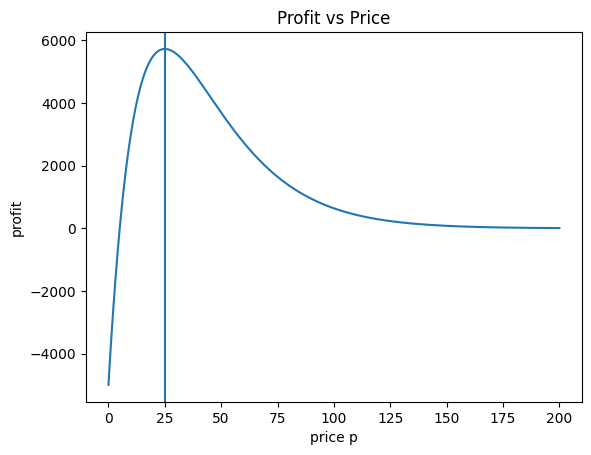

In [ ]:
import matplotlib.pyplot as plt

ps = np.linspace(0, 200, 201)
profits = [(p - unit_cost) * demand(p) for p in ps]

plt.figure()
plt.plot(ps, profits)
plt.axvline(p_star)
plt.xlabel("price p")
plt.ylabel("profit")
plt.title("Profit vs Price")
plt.show()


## 6. Tổng kết: kỹ thuật cổ điển nằm ở đâu trong ML/AI pipeline?

- Regression: baseline + interpretability + sanity check
- Hypothesis testing: kiểm chứng claim + hiểu dữ liệu + A/B style reasoning
- Optimization: ra quyết định dưới ràng buộc, thường đứng sau ML


# Bài tập về nhà
1) Trả lời tất cả câu hỏi bắt buộc trong notebook (ngắn gọn, 3–6 dòng/câu).
2) Thay bài toán LP bằng một kịch bản liên quan đến project của nhóm bạn (tối thiểu 2 ràng buộc).
3) Với dữ liệu đồ án:
   - đề xuất 1 baseline hồi quy hoặc kiểm định giả thuyết phù hợp
   - mô tả rủi ro p-hacking hoặc leakage có thể gặp


## 0. Setup & Reproducibility
Cố định seed, in versions, tạo thư mục outputs.

In [23]:
# 0) Setup
import json, os, sys, platform
from datetime import datetime

import numpy as np
import pandas as pd
import sklearn

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

OUTPUT_DIR = "outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("python:", sys.version)
print("platform:", platform.platform())
print("numpy:", np.__version__)
print("pandas:", pd.__version__)
print("sklearn:", sklearn.__version__)


python: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
platform: Linux-6.6.105+-x86_64-with-glibc2.35
numpy: 2.0.2
pandas: 2.2.2
sklearn: 1.6.1


## 1. Dataset (dữ liệu mẫu cho regression + hypothesis testing)


Nghiên cứu sử dụng dataset **[Retail Store Inventory and Demand Forecasting](https://www.kaggle.com/datasets/atomicd/retail-store-inventory-and-demand-forecasting/data)**
được công bố trên Kaggle.

- Target: `Demand` – đại diện cho nhu cầu (demand), là biến liên tục, phù hợp với bài toán regression và demand forecasting.
- Feature: bao gồm các yếu tố liên quan đến tồn kho, giá bán và thời gian (`inventory level`, `price`, `date`), được chuẩn hóa để phục vụ huấn luyện mô hình học máy.

Dataset này phù hợp cho mục tiêu dự báo nhu cầu và làm đầu vào cho bài toán đề xuất mức tồn kho an toàn (safety stock).





In [2]:
!pip install -q kagglehub[pandas-datasets]

In [24]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

file_path = "sales_data.csv"

df = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "atomicd/retail-store-inventory-and-demand-forecasting",
    file_path,
)

df.head()


/tmp/ipython-input-1143135028.py:6: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  df = kagglehub.load_dataset(


Using Colab cache for faster access to the 'retail-store-inventory-and-demand-forecasting' dataset.


,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Price,Discount,Weather Condition,Promotion,Competitor Pricing,Seasonality,Epidemic,Demand
0,2022-01-01,S001,P0001,Electronics,North,195,102,252,72.72,5,Snowy,0,85.73,Winter,0,115
1,2022-01-01,S001,P0002,Clothing,North,117,117,249,80.16,15,Snowy,1,92.02,Winter,0,229
2,2022-01-01,S001,P0003,Clothing,North,247,114,612,62.94,10,Snowy,1,60.08,Winter,0,157
3,2022-01-01,S001,P0004,Electronics,North,139,45,102,87.63,10,Snowy,0,85.19,Winter,0,52
4,2022-01-01,S001,P0005,Groceries,North,152,65,271,54.41,0,Snowy,0,51.63,Winter,0,59


In [25]:
print("shape:", df.shape)
df.describe().T.head(12)

shape: (76000, 16)


,count,mean,std,min,25%,50%,75%,max
Inventory Level,76000.0,301.062842,226.510161,0.00,136.0000,227.0,408.0000,2267.00
Units Sold,76000.0,88.827316,43.994525,0.00,58.0000,84.0,114.0000,426.00
Units Ordered,76000.0,89.090645,162.404627,0.00,0.0000,0.0,121.0000,1616.00
Price,76000.0,67.726028,39.377899,4.74,31.9975,64.5,95.8300,228.03
Discount,76000.0,9.087039,7.475781,0.00,5.0000,10.0,10.0000,25.00
Promotion,76000.0,0.328947,0.469834,0.00,0.0000,0.0,1.0000,1.00
Competitor Pricing,76000.0,69.454029,40.943818,4.29,32.6200,65.7,97.9325,261.22
Epidemic,76000.0,0.200000,0.400003,0.00,0.0000,0.0,0.0000,1.00
Demand,76000.0,104.317158,46.964801,4.00,71.0000,100.0,133.0000,430.00


## 2. Hồi quy tuyến tính (Linear Regression) như baseline + interpretability
### **Câu hỏi**
1) Với dữ liệu của nhóm bạn, hồi quy tuyến tính có thể là baseline không? Vì sao?

Hồi quy tuyến tính (Ordinary Least Squares – OLS) phù hợp làm baseline cho dataset Retail Inventory & Demand.

- OLS cung cấp mối quan hệ tuyến tính trực tiếp giữa feature (inventory, price, time) và demand.
- sales_quantity là biến liên tục → đúng bản chất bài toán regression.
- Baseline phổ biến trong nhiều nghiên cứu demand forecasting


2) Nếu feature có quan hệ phi tuyến, dấu hiệu nào cho thấy OLS không phù hợp?
- Residual không phân bố ngẫu nhiên
- Quan hệ giữa feature–target không tuyến tính.
- Feature engineering (interaction terms, polynomial features) tuyến tính không cải thiện

Hướng xử lý: sử dụng các mô hình Tree-based, LSTM, hoặc hybrid

In [26]:
df["Date"] = pd.to_datetime(df["Date"])

df_agg = (
    df.groupby(["Date", "Store ID", "Product ID"], as_index=False)
      .agg({
          "Demand": "sum",
          "Units Sold": "sum",
          "Units Ordered": "sum",
          "Inventory Level": "mean",
          "Price": "mean",
          "Discount": "mean",
          "Competitor Pricing": "mean",
          "Promotion": "max",
          "Epidemic": "max",
          "Category": "first",
          "Region": "first",
          "Seasonality": "first",
          "Weather Condition": "first"
      })
)


### 2.1 Train/Test split (để tránh đánh giá ảo)

1. Đảm bảo dữ liệu được xếp theo thứ tự thời gian tăng dần
2. Lấy 80% dữ liệu đầu làm train, 20% dữ liệu cuối làm test
3. Giữ nguyên trật tự thời gian, ko random

In [27]:
df = df.sort_values("Date")
df["Date"] = pd.to_datetime(df["Date"])
df["day"] = df["Date"].dt.day
df["month"] = df["Date"].dt.month
df["dow"] = df["Date"].dt.dayofweek

df = df.drop(columns=["Date"])

df = df.rename(columns={"Demand": "y"})

split_idx = int(len(df) * 0.8)

train_df = df.iloc[:split_idx]
test_df  = df.iloc[split_idx:]

X_train = train_df.drop(columns=["y"])
y_train = train_df["y"]

X_test  = test_df.drop(columns=["y"])
y_test  = test_df["y"]


print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)



(60800, 17) (60800,)
(15200, 17) (15200,)


### 2.2 Linear regression bằng scikit-learn

In [28]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


linreg = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LinearRegression())
])

X_train = pd.get_dummies(X_train, drop_first=True)
X_test  = pd.get_dummies(X_test, drop_first=True)

X_train, X_test = X_train.align(X_test, join="left", axis=1, fill_value=0)


linreg.fit(X_train, y_train)
pred = linreg.predict(X_test)

mae = mean_absolute_error(y_test, pred)
mse = mean_squared_error(y_test, pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, pred)

{"test_MAE": mae, "test_RMSE": rmse, "test_R2": r2}


{'test_MAE': 15.565123766327114,
 'test_RMSE': np.float64(20.80699383343284),
 'test_R2': 0.7772556054536474}

### 2.3 Hồi quy OLS bằng statsmodels để xem hệ số và p-values

In [29]:
import statsmodels.api as sm

X_train_sm = X_train.copy()

X_train_sm = pd.get_dummies(X_train_sm, drop_first=True)
X_train_sm = X_train_sm.astype(float)
X_train_sm = sm.add_constant(X_train_sm)
ols = sm.OLS(y_train.astype(float), X_train_sm).fit()
ols.summary()



# X_train_sm = sm.add_constant(X_train)  # thêm intercept
# ols = sm.OLS(y_train, X_train_sm).fit()
# ols.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.779
Model:                            OLS   Adj. R-squared:                  0.779
Method:                 Least Squares   F-statistic:                     4867.
Date:                Sun, 01 Feb 2026   Prob (F-statistic):               0.00
Time:                        14:28:34   Log-Likelihood:            -2.7524e+05
No. Observations:               60800   AIC:                         5.506e+05
Df Residuals:                   60755   BIC:                         5.510e+05
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      27.1694      0.605     44.934      0.000      25.984      28.355
Inventory Level            -0.0119      0.000    -26.770      0.000      -0.013      -0.011
Units Sold                  0.6499      0.003    237.288      0.000       0.645       0.655
Units Ordered               0.0484      0.001     76.636      0.000       0.047       0.050
Price                       0.1567      0.011     14.137      0.000       0.135       0.178
Discount                    0.1088      0.020      5.482      0.000       0.070       0.148
Promotion                  10.2134      0.317     32.231      0.000       9.592      10.834
Competitor Pricing          0.0380      0.010      3.679      0.000       0.018       0.058
Epidemic                  -17.5006      0.254    -68.790      0.000     -17.999     -17.002
day                        -0.0007      0.010     -0.066      0.947      -0.021       0.020
month                      -0.0595      0.041     -1.468      0.142      -0.139       0.020
dow                        -0.0326      0.045     -0.718      0.473      -0.122       0.056
Store ID_S002               3.8707      0.140     27.657      0.000       3.596       4.145
Store ID_S003               9.0483      0.271     33.398      0.000       8.517       9.579
Store ID_S004               4.7391      0.136     34.924      0.000       4.473       5.005
Store ID_S005               0.2301      0.291      0.790      0.430      -0.341       0.801
Product ID_P0002            2.3024      0.578      3.984      0.000       1.170       3.435
Product ID_P0003           -2.0713      0.592     -3.499      0.000      -3.231      -0.911
Product ID_P0004           -1.7349      0.578     -3.000      0.003      -2.868      -0.602
Product ID_P0005           -1.7214      0.580     -2.967      0.003      -2.858      -0.584
Product ID_P0006           -1.8942      0.588     -3.223      0.001      -3.046      -0.742
Product ID_P0007            0.0964      0.581      0.166      0.868      -1.042       1.235
Product ID_P0008           -0.3012      0.590     -0.510      0.610      -1.459       0.856
Product ID_P0009           -6.7440      0.614    -10.976      0.000      -7.948      -5.540
Product ID_P0010           -2.5013      0.588     -4.256      0.000      -3.653      -1.350
Product ID_P0011           -6.8309      0.610    -11.198      0.000      -8.027      -5.635
Product ID_P0012           -3.5274      0.601     -5.873      0.000      -4.705      -2.350
Product ID_P0013           -0.7271      0.581     -1.252      0.211      -1.866       0.411
Product ID_P0014           -9.9597      0.628    -15.857      0.000     -11.191      -8.729
Product ID_P0015           -3.0478      0.588     -5.187      0.000      -4.200      -1.896
Product ID_P0016           -2.5405      0.590  

**R-squared** = 0.779 (Adj. R² = 0.779)
- Mô hình giải thích được ~78% biến thiên của Demand

**F-statistic** = 4867, Prob(F-statistic) = 0.00

- Kiểm định giả thuyết: H₀: tất cả hệ số = 0

- p-value ≈ 0 → bác bỏ H₀ ⇒ Mô hình có ý nghĩa thống kê tổng thể


**Ý nghĩa các biến chính**
- Inventory Level: coef = -0.0119 (p < 0.001)
  - Tồn kho cao → Demand ghi nhận thấp hơn

- Units Sold: coef = 0.6499 (p < 0.001)
  - Bán được nhiều → nhu cầu cao

- Units Ordered: coef = 0.0484 (p < 0.001)
  - Đặt hàng nhiều → kỳ vọng cầu cao

- Promotion: coef ≈ +10.2 (p < 0.001)
  - Có khuyến mãi → Demand tăng trung bình ~10 đơn vị/ngày

- Epidemic: coef ≈ -17.5 (p < 0.001)
  - Dịch bệnh → Demand giảm mạnh

- Store ID: Cửa hàng khác nhau có mức cầu nền khác nhau
  - S002, S003, S004: tác động dương và có ý nghĩa
  - S005: không có ý nghĩa

- Product ID: Nhiều sản phẩm có coef âm lớn (P0014, P0011, P0009…)
- Category: Ngành hàng quyết định mức cầu nền
  - Furniture: −27.5 (rất mạnh)
  - Electronics: −8.1
  - Groceries: +7.9


### 2.4 Chẩn đoán nhanh: residuals (dấu hiệu phi tuyến / outliers)

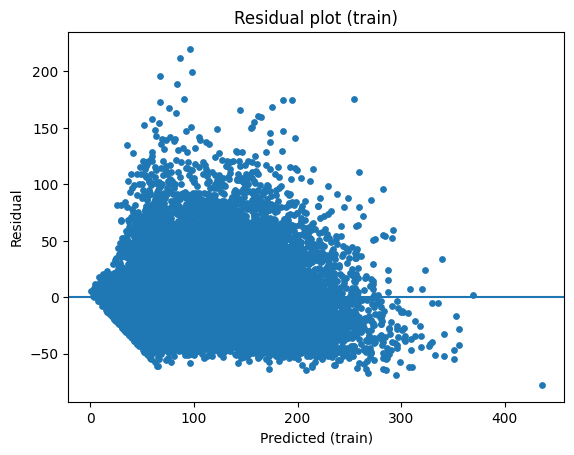

In [30]:
import matplotlib.pyplot as plt

pred_train = ols.predict(sm.add_constant(X_train))
resid = y_train - pred_train

plt.figure()
plt.scatter(pred_train, resid, s=15)
plt.axhline(0)
plt.xlabel("Predicted (train)")
plt.ylabel("Residual")
plt.title("Residual plot (train)")
plt.show()


## 3. Hồi quy phi tuyến (Non-linear regression) dưới dạng feature engineering

Thay vì đi sâu các mô hình phi tuyến cổ điển, ta dùng cách thực dụng:
- **Polynomial features + regularization** để bắt quan hệ phi tuyến
- So sánh với OLS baseline

### Vai trò trong pipeline
- Tạo baseline phi tuyến đơn giản trước khi dùng tree/NN
- Cho thấy lợi ích của feature engineering

### **Câu hỏi**
1) Polynomial degree tăng sẽ gây rủi ro gì?
- Multicollinearity nghiêm trọng
- Degree càng cao thì feature tăng theo cấp số nhân
- Overfitting: Polynomial bậc cao có khả năng khớp nhiễu thay vì quy luật thực


2) Vì sao regularization (Ridge/Lasso) thường cần khi thêm polynomial features?
- Ổn định hệ số (coefficient shrinkage)
- Giảm overfitting
- Lựa chọn đặc trưng (Lasso)

In [16]:
print(type(X_train), X_train.shape)
num_cols = X_train.select_dtypes(
    include=["int64", "float64"]
).columns


<class 'pandas.core.frame.DataFrame'> (60800, 47)


In [12]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline


poly_ridge = Pipeline([
    ("scaler", StandardScaler()),
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ("model", Ridge(alpha=10.0))
])

X_train_num = X_train[num_cols]
X_test_num  = X_test[num_cols]

poly_ridge.fit(X_train_num, y_train)
pred = poly_ridge.predict(X_test_num)


# param_grid = {
#     "poly__degree": [1, 2, 3],
#     "model__alpha": [0.1, 1.0, 10.0, 100.0],
# }

param_grid = {
    "poly__degree": [2],
    "model__alpha": [1.0, 10.0],
}


gs = GridSearchCV(poly_ridge, param_grid, cv=5, scoring="neg_mean_absolute_error")
gs.fit(X_train, y_train)

best = gs.best_estimator_
pred = best.predict(X_test)

mae = mean_absolute_error(y_test, pred)
mse = mean_squared_error(y_test, pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, pred)

gs.best_params_, {"test_MAE": mae, "test_RMSE": rmse, "test_R2": r2}


({'model__alpha': 10.0, 'poly__degree': 2},
 {'test_MAE': 6.271738442868993,
  'test_RMSE': np.float64(9.05877412599997),
  'test_R2': 0.9577791503598768})

## Minh hoạ assumption violation gây sai lệch

- heteroscedasticity
- multicollinearity
- overfitting khi degree tăng

In [ ]:
from sklearn.metrics import mean_absolute_error

for deg in [1,2]:
    model = Pipeline([
        ("scaler", StandardScaler()),
        ("poly", PolynomialFeatures(degree=deg, include_bias=False)),
        ("lr", LinearRegression())
    ])
    model.fit(X_train, y_train)
    print("degree", deg, "MAE", mean_absolute_error(y_test, model.predict(X_test)))


degree 1 MAE 15.565123766327023
degree 2 MAE 6.291267337631229


## 4. Kiểm chứng giả thuyết (Hypothesis Testing) để kiểm tra claim

### Vai trò trong pipeline ML/AI
- Kiểm tra khác biệt giữa nhóm (A/B, cohort, segment)
- Kiểm tra feature có liên hệ đáng kể với target không
- Hỗ trợ data understanding và error analysis

### Giới hạn và rủi ro
- p-value không đo “mức độ quan trọng thực tế” (cần effect size, CI)
- Nhiều phép thử -> tăng false positives (p-hacking)
- Giả định phân phối có thể không đúng -> cân nhắc permutation/bootstrapping

### **Câu hỏi**
1) p-value nhỏ nghĩa là gì? p-value không có nghĩa là gì?

p-value nhỏ (ví dụ < 0.05) nghĩa là:

- Nếu giả thuyết không (H₀) là đúng, thì xác suất quan sát được kết quả ít nhất cực đoan như dữ liệu hiện tại là nhỏ.
- Dữ liệu không phù hợp với H₀ → có bằng chứng để bác bỏ H₀ (ở mức ý nghĩa đã chọn).

2) Vì sao cần effect size/CI bên cạnh p-value?
- Effect size trả lời câu hỏi “lớn đến mức nào?”
  - Giá giảm 0.1% làm demand tăng 0.02% → p-value = 0.0001 → có ý nghĩa thống kê, nhưng vô nghĩa thực tế

- Confidence Interval cho biết độ bất định: CI rộng = mô hình / dữ liệu chưa đủ mạnh
- Effect size + CI giúp ra quyết định: Trong pipeline ML/AI, Feature selection, Business rule → Quyết định không thể dựa vào p-value

### 4.1 Tạo 2 nhóm theo feature `sex`
Trong dataset này, `sex` đã chuẩn hóa quanh 0. Ta tách nhóm theo dấu.

In [17]:
df2 = df.copy()

# Tạo 2 nhóm theo Promotion
# 0 = không khuyến mãi, 1 = có khuyến mãi
df2["promo_group"] = np.where(
    df2["Promotion"] == 1,
    "promotion",
    "no_promotion"
)

# Kiểm tra số lượng và mean của target
df2["promo_group"].value_counts(), df2.groupby("promo_group")["y"].mean()

(promo_group
 no_promotion    51000
 promotion       25000
 Name: count, dtype: int64,
 promo_group
 no_promotion     95.026843
 promotion       123.269400
 Name: y, dtype: float64)

### 4.2 Two-sample t-test (so sánh trung bình y giữa 2 nhóm)

In [18]:
from scipy import stats

# Lấy 2 nhóm theo Promotion
a = df2.loc[df2["promo_group"] == "promotion", "y"].values
b = df2.loc[df2["promo_group"] == "no_promotion", "y"].values

# Welch’s t-test (không giả định phương sai bằng nhau)
t_stat, p_val = stats.ttest_ind(a, b, equal_var=False)

t_stat, p_val


(np.float64(74.3362487472862), np.float64(0.0))

### 4.3 Effect size (Cohen's d) + confidence interval (bootstrap)

In [31]:
def cohens_d(x, y):
    nx, ny = len(x), len(y)
    vx, vy = np.var(x, ddof=1), np.var(y, ddof=1)
    pooled = ((nx-1)*vx + (ny-1)*vy) / (nx+ny-2)
    return (np.mean(x) - np.mean(y)) / np.sqrt(pooled)

d = cohens_d(a, b)
d


np.float64(0.6268938501902926)

In [38]:
# Bootstrap CI for mean difference
def bootstrap_mean_diff(x, y, n=5000, seed=RANDOM_SEED):
    rng = np.random.default_rng(seed)
    diffs = []
    for _ in range(n):
        xb = rng.choice(x, size=len(x), replace=True)
        yb = rng.choice(y, size=len(y), replace=True)
        diffs.append(np.mean(xb) - np.mean(yb))
    return np.percentile(diffs, [2.5, 50, 97.5])

ci = bootstrap_mean_diff(a, b)
ci  # [2.5%, 50%, 97.5%]


array([27.4829928 , 28.24117216, 28.9888132 ])

### 4.4 Permutation test (khi muốn giảm phụ thuộc vào giả định phân phối)

In [33]:
def permutation_test_mean_diff(x, y, n=5000, seed=RANDOM_SEED):
    rng = np.random.default_rng(seed)
    obs = np.mean(x) - np.mean(y)
    pooled = np.concatenate([x, y]).copy()
    nx = len(x)
    diffs = []
    for _ in range(n):
        rng.shuffle(pooled)
        diffs.append(np.mean(pooled[:nx]) - np.mean(pooled[nx:]))
    diffs = np.array(diffs)
    p = (np.abs(diffs) >= abs(obs)).mean()
    return obs, p

obs, p_perm = permutation_test_mean_diff(a, b)
obs, p_perm


(np.float64(28.242556862745104), np.float64(0.0))

## Minh hoạ về multiple testing và p-hacking
- H0 đúng (không có hiệu ứng thật)
- nhưng ta thử rất nhiều cấu hình (crossing, threshold, segment, interaction…)
- cuối cùng vẫn “đào được” vài p-value < 0.05

**Set up:** Shuffle y ngẫu nhiên -> bảo đảm không feature nào thực sự liên quan.

**Candidate features:**
- feature gốc: $x_i$
- interaction 2 biến: $x_i x_j$
- interaction 3 biến: $x_i x_j x_k$

>Không phải cứ p < 0.05 là có phát hiện thật. Khi thử hàng nghìn cấu hình, xác suất đào được vài p nhỏ là hiển nhiên.

In [41]:
X_df = X.select_dtypes(include=[np.number]).copy()


In [42]:
from itertools import combinations
from scipy import stats
import numpy as np
import pandas as pd

# 1) Make H0 true
rng = np.random.default_rng(42)
y_null = rng.permutation(y.values)

# 2) Candidate features (numeric only)
candidates = []

# single features
for c in X_df.columns:
    candidates.append((c, X_df[c].values))

# pairwise interactions
for c1, c2 in combinations(X_df.columns, 2):
    candidates.append((f"{c1}*{c2}", X_df[c1].values * X_df[c2].values))

# triple interactions (rất dễ p-hacking)
for c1, c2, c3 in combinations(X_df.columns, 3):
    candidates.append(
        (f"{c1}*{c2}*{c3}",
         X_df[c1].values * X_df[c2].values * X_df[c3].values)
    )

# 3) p-values
rows = []
for name, z in candidates:
    r, p = stats.pearsonr(z, y_null)
    rows.append((name, r, p))

res = pd.DataFrame(rows, columns=["feature", "r", "p"]).sort_values("p")
res.head(15)


,feature,r,p
17,Inventory Level*Epidemic,-0.007464,0.039628
139,Units Sold*Competitor Pricing*month,-0.006808,0.060533
194,Price*day*dow,0.006729,0.063593
225,Competitor Pricing*day*dow,0.006604,0.068683
124,Units Sold*Price*month,-0.006079,0.093748
74,Inventory Level*Units Sold*dow,0.006076,0.093931
200,Discount*Promotion*dow,0.006050,0.095351
105,Inventory Level*Epidemic*day,-0.005959,0.100405
11,Inventory Level*Units Sold,0.005867,0.105819
101,Inventory Level*Competitor Pricing*Epidemic,-0.005834,0.107787


### Áp dụng Bonferroni correction

>Sau correction, p-value sau điều chỉnh không còn “ý nghĩa” ảo nữa.

In [43]:
m = len(res)
res["p_bonf"] = np.minimum(res["p"] * m, 1.0)
res.head(15)


,feature,r,p,p_bonf
17,Inventory Level*Epidemic,-0.007464,0.039628,1.0
139,Units Sold*Competitor Pricing*month,-0.006808,0.060533,1.0
194,Price*day*dow,0.006729,0.063593,1.0
225,Competitor Pricing*day*dow,0.006604,0.068683,1.0
124,Units Sold*Price*month,-0.006079,0.093748,1.0
74,Inventory Level*Units Sold*dow,0.006076,0.093931,1.0
200,Discount*Promotion*dow,0.006050,0.095351,1.0
105,Inventory Level*Epidemic*day,-0.005959,0.100405,1.0
11,Inventory Level*Units Sold,0.005867,0.105819,1.0
101,Inventory Level*Competitor Pricing*Epidemic,-0.005834,0.107787,1.0


## 5. Tối ưu (Optimization) như một module trong hệ thống dữ liệu

### Vai trò trong pipeline ML/AI
- Sau khi dự báo/ước lượng (ML), ta cần **ra quyết định** (optimization)
- Ví dụ:
  - dự báo nhu cầu -> tối ưu tồn kho
  - dự báo churn -> tối ưu phân bổ ngân sách giữ chân
  - scoring khách hàng -> tối ưu chọn top-K theo ràng buộc

### Bài lab: 2 bài toán minh họa
A) Linear Programming: tối ưu product mix (tuyến tính, ràng buộc tuyến tính)  
B) Non-linear Optimization: tối ưu giá (có độ cong, không tuyến tính)

### **Câu hỏi**
1) Vì sao optimization thường đứng sau ML trong hệ thống thực?

- ML chỉ cung cấp ước lượng / dự báo (inputs).
- Optimization mới là bước chuyển dự báo → hành động.

2) Khi nào mô hình tối ưu tuyến tính không phù hợp?

LP không phù hợp khi vi phạm các giả định sau:
- Quan hệ phi tuyến
- Có tương tác giữa biến quyết định
- Biến quyết định rời rạc / logic
- Ràng buộc dựa trên xác suất / rủi ro


### 5A. Linear Programming (LP): Product mix optimization
Bài toán: chọn sản lượng 3 sản phẩm để tối đa lợi nhuận, bị giới hạn bởi tài nguyên.

In [47]:
import numpy as np
from scipy.optimize import linprog

n = len(D)

# Decision variables: [Q1..Qn, S1..Sn]
# Q = reorder, S = shortage

# Objective: holding + shortage penalty
obj = np.concatenate([h, p])

# Constraints
# 1) I + Q + S >= αD  ->  -Q - S <= I - αD
A_service = np.hstack([
    -np.eye(n),      # Q
    -np.eye(n)       # S
])
b_service = I - service_level * D

# 2) Budget: Σ c_i Q_i ≤ budget
A_budget = np.hstack([c.reshape(1, -1), np.zeros((1, n))])
b_budget = [budget]

A_ub = np.vstack([A_service, A_budget])
b_ub = np.concatenate([b_service, b_budget])

bounds = [(0, None)] * (2 * n)

res = linprog(c=obj, A_ub=A_ub, b_ub=b_ub, bounds=bounds, method="highs")

Q_opt = res.x[:n]
S_opt = res.x[n:]

{
    "Q_optimal": Q_opt,
    "expected_shortage": S_opt,
    "total_cost": c @ Q_opt,
    "success": res.success
}


{'Q_optimal': array([74.        , 46.        , 78.66666667]),
 'expected_shortage': array([0.        , 0.        , 3.83333333]),
 'total_cost': np.float64(2000.0),
 'success': True}

### 5B. Non-linear optimization: Pricing
Giả sử Giá ↑ → demand ↓ (phi tuyến)


Ta chọn giá sao cho: demand(price) ≈ available inventory

Trong trường hợp không có dữ liệu lợi nhuận rõ ràng, việc định giá được xây dựng như một bài toán tối ưu hóa phi tuyến nhằm giảm thiểu sự chênh lệch giữa cung và cầu, trong đó cầu được mô hình hóa như một hàm phi tuyến của giá cả.

In [55]:
import numpy as np
from scipy.optimize import minimize

# ==== Inputs từ inventory data ====
I = 500          # Inventory Level (aggregate / average)
p0 = 30.0        # Current price
a, b = 1200, 0.04  # learned từ data (fit trước đó)

# Demand model
def demand(p):
    return a * np.exp(-b * p)

# Objective: match demand to inventory + price stability
def objective(p_vec):
    p = p_vec.item()
    q = demand(p)

    mismatch_cost = (q - I) ** 2
    price_penalty = 0.1 * (p - p0) ** 2

    return mismatch_cost + price_penalty

res = minimize(
    objective,
    x0=[p0],
    bounds=[(1.0, 200.0)]
)

p_star = res.x.item()
q_star = demand(p_star)

{"p_star": p_star, "expected_demand": q_star, "inventory": I}


{'p_star': 21.888746489581607,
 'expected_demand': np.float64(499.95944053047737),
 'inventory': 500}

### 5B.1 Visualize profit curve (để hiểu tối ưu)

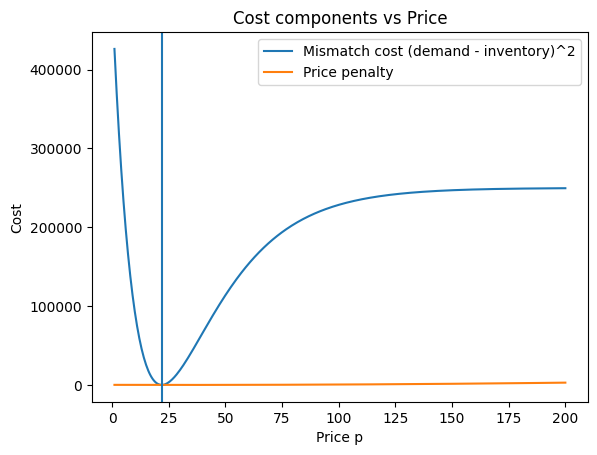

In [56]:
plt.figure()
plt.plot(ps, mismatch_vals, label="Mismatch cost (demand - inventory)^2")
plt.plot(ps, price_penalty_vals, label="Price penalty")
plt.axvline(p_star)
plt.xlabel("Price p")
plt.ylabel("Cost")
plt.title("Cost components vs Price")
plt.legend()
plt.show()


## 6. Tổng kết: kỹ thuật cổ điển nằm ở đâu trong ML/AI pipeline?

- Regression: baseline + interpretability + sanity check
- Hypothesis testing: kiểm chứng claim + hiểu dữ liệu + A/B style reasoning
- Optimization: ra quyết định dưới ràng buộc, thường đứng sau ML
